In [2]:
### DOWNLOAD AND UNZIP DATASET
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar xvzf cifar-10-python.tar.gz

--2023-04-28 16:48:50--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz.1’

cifar-10-python.tar 100%[===================>] 162.60M  82.9MB/s    in 2.0s    

2023-04-28 16:48:53 (82.9 MB/s) - ‘cifar-10-python.tar.gz.1’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [52]:
### IMPORTANT RELEVANT LIBRARIES
import os
import pickle
import itertools
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
from tqdm import tqdm

In [53]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
### DATA UTILITIES
def unpickle(file):
    with open(file, "rb") as fo:
        dict = pickle.load(fo, encoding="bytes")
    return dict    

class Dataset:
    def __init__(self, filepath, batch_size=32, sample_interval=1):
        
        self.filepath = filepath
        self.batch_size = batch_size
        
        all_files = os.listdir(self.filepath)
        
        train_files = [os.path.join(self.filepath, file) for file in all_files if file[:4] == "data"]
        test_files = [os.path.join(self.filepath, file) for file in all_files if file[:4] == "test"]
        
        train_dict = [unpickle(train_file) for train_file in train_files]
        test_dict = [unpickle(test_file) for test_file in test_files]
        
        train_X_list = [data_dict[b"data"] for data_dict in train_dict]
        train_y_list = [data_dict[b"labels"] for data_dict in train_dict]
        test_X_list = [data_dict[b"data"] for data_dict in test_dict]
        test_y_list = [data_dict[b"labels"] for data_dict in test_dict]
        
        self.X_train = np.vstack(train_X_list)[0:-1:sample_interval, :]
        self.X_test = np.vstack(test_X_list)[0:-1:sample_interval, :]
        self.y_train = np.array(list(itertools.chain(*train_y_list)))[0:-1:sample_interval]
        self.y_test = np.array(list(itertools.chain(*test_y_list)))[0:-1:sample_interval]
        
        self.num_train_samples, self.num_test_samples = self.X_train.shape[0], self.X_test.shape[0]
        
        self.num_train_batches =  ceil(self.num_train_samples/self.batch_size)
        self.num_test_batches = ceil(self.num_test_samples/self.batch_size )
        
        self.train_mean, self.train_std = np.mean(self.X_train, axis=0), np.std(self.X_train, axis=0)

    def visualize(self, idx):
        plt.imshow(np.moveaxis(self.X_train[idx].reshape((3,32,32)), source=0, destination=-1))
        plt.title(classes[self.y_train[idx]])
        plt.show()

    def train_batch(self, batch_idx):
        start_idx = batch_idx * self.batch_size
        end_idx = min((batch_idx+1)*self.batch_size, self.num_train_samples)
        X, y = self.X_train[start_idx:end_idx, :], self.y_train[start_idx:end_idx]
        X = (X-self.train_mean)/self.train_std ### BATCH_SIZE * (H*W*C)
        X = X.reshape((-1, 3, 32, 32)) ## BATCH_SIZE * C * H * W
        return X, y
    
    def test_batch(self, batch_idx):
        start_idx = batch_idx * self.batch_size
        end_idx = min((batch_idx+1)*self.batch_size, self.num_test_samples)
        X, y = self.X_test[start_idx:end_idx, :], self.y_test[start_idx:end_idx]
        X = (X - self.train_mean)/self.train_std ## BATCH_SIZE * (H*W*C)
        X = X.reshape((-1, 3, 32, 32)) ## BATCH_SIZE * C * H * W
        return X, y

In [56]:
### OPTIMIZER
class AdamOptimizer():
    
    def __init__(self, shape, alpha, beta1=0.9, beta2=0.99, eps=1e-8): 
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.num_updates = 0
        self.v_dw = np.zeros(shape)
        self.s_dw = np.zeros(shape)
        
    def update(self, w, w_grad, printing=False):
        
        self.num_updates += 1
        
        self.v_dw = self.beta1 * self.v_dw + (1-self.beta1)*w_grad
        self.s_dw = self.beta2 * self.s_dw + (1-self.beta2)*(w_grad ** 2)
        
        v_dw_correct = self.v_dw / (1-(self.beta1**self.num_updates))
        s_dw_correct = self.s_dw / (1-(self.beta2**self.num_updates))
        if(printing):
            print(self.alpha * (v_dw_correct / (np.sqrt(s_dw_correct) + self.eps)))
        return w - self.alpha * (v_dw_correct / (np.sqrt(s_dw_correct) + self.eps) )

In [61]:
class Linear:
    
    def __init__(self, in_features, out_features, learning_rate):
       
        self.in_features, self.out_features = in_features, out_features
        self.W = np.random.uniform(low=-0.1, high=+0.1, size=(in_features, out_features))
        self.b = np.zeros(shape=(out_features,))
        self.learning_rate = learning_rate
        self.W_optimizer = AdamOptimizer(shape=self.W.shape, alpha=learning_rate)
        self.b_optimizer = AdamOptimizer(shape=self.b.shape, alpha=learning_rate)
        
    def forward(self, X):
        ### X is M * D_in
        ## X.W + b ===> X (M * D_IN ) . W (D_IN * D_OUT) + b (D_out)
        self.cache_X = X
        return np.matmul(X, self.W) + self.b

    def backward(self, delY):
        ### delY => M * D_out
        ### each term is the gradient of the scalar loss wrt the corresponding element in the input
        self.W_grad = np.matmul(self.cache_X.T, delY)
        self.b_grad = np.sum(delY, axis=0)
        delX = np.matmul(delY, self.W.T)
        return delX
    
    def update(self):
        
        self.W = self.W_optimizer.update(self.W, self.W_grad)
        self.b = self.b_optimizer.update(self.b, self.b_grad)
    
class ReLU:
    def __init_(self):
        pass
    
    def forward(self, X):
        ## Y = ReLU(X)
        self.X_cache = X
        return np.maximum(X, 0)
    
    def backward(self, delY):
        return np.where(self.X_cache >= 0, 1, 0) * delY
    
class SoftMax:
    def __init__(self):
        pass
    
    def forward(self, X):
        ## Y = softmax(X) || X => M * NUM_CLASSES
        self.X_cache = X
        denominator = np.sum(np.exp(X), axis=1, keepdims=True) ## M, 1
        self.prob_X_cache =  np.exp(X) / denominator
        return self.prob_X_cache
    
    def backward(self, delY):
        ### Y is M * NUM_CLASSES
        self.ans = np.zeros(shape=(self.X_cache.shape))
        for sample_idx in range(self.X_cache.shape[0]):
            prob = self.prob_X_cache[sample_idx] ### probabilities for this data point ||| (NUM_CLASSES, )
            A = np.diag(prob) - np.matmul(prob.reshape((-1,1)), prob.reshape(1, -1))
            self.ans[sample_idx] =  np.matmul(delY[sample_idx, :].reshape(1, -1), A).reshape(-1)
        return self.ans
        
class Flatten():
    def __init__(self):
        pass
    def forward(self, X):
        ## X => B * C * H * W
        ## Y => B * (C*H*W)
        self.cache = X.shape
        return X.reshape((X.shape[0], -1)) 
    def backward(self, delY):
        ## delY => B * (C*H*W) || delX => B * C * H * W 
        return delY.reshape(self.cache)
    
class MaxPool2D():
    
    def __init__(self, kernel_size=2, stride=2):
        self.kernel_size = kernel_size
        self.stride = stride
        
    def forward_helper(self, h, w, X):
        (N, C_in, H_in, W_in) = X.shape
        h_start, h_end = h * self.stride, h * self.stride + self.kernel_size
        w_start, w_end = w * self.stride, w * self.stride + self.kernel_size
        input_slice = X[:, :, h_start:h_end, w_start:w_end]
        return np.expand_dims(np.max(input_slice.reshape(N, C_in, -1), axis=2), axis=2)
        
    def forward(self, X):
        ## X ==> N * C * H * W
        (N, C_in, H_in, W_in) = X.shape
        self.cache = X
        C_out, H_out, W_out = C_in, (H_in-self.kernel_size)//self.stride + 1, (W_in-self.kernel_size)//self.stride+1
        # output = Parallel(n_jobs=2)(delayed(self.forward_helper)(h, w, X) for h in range(H_out) for w in range(W_out))
        # output = np.reshape(np.concatenate(output, axis=2), newshape=(N, C_in, H_out, W_out))
        output = np.zeros((N, C_out, H_out, H_out))
        ## iterating over the output axises
        for h in range(H_out):
            for w in range(W_out):
                ### input to consider
                h_start, h_end = h * self.stride, h * self.stride + self.kernel_size
                w_start, w_end = w * self.stride, w * self.stride + self.kernel_size
                input_slice = X[:, :, h_start:h_end, w_start:w_end] ## B * C_in * kernel_size * kernel_size
                output[:, :, h, w] = np.max(input_slice.reshape(N, C_in, -1), axis=2)
                    
        return output
    
    def backward(self, delY):
        ## delY => N * C * H_out * W_out ||| delX => N * C * H_in * W_in
        (N, C_out, H_out, W_out) = delY.shape
        output = np.zeros(self.cache.shape) ## shape of input to this layer
        ## iterating over the output
        # for channel in range(C_out):
        for h in range(H_out):
            for w in range(W_out):
                ### input to consider
                h_start, h_end = h * self.stride, h * self.stride + self.kernel_size
                w_start, w_end = w * self.stride, w * self.stride + self.kernel_size
                input_slice = self.cache[:, :, h_start:h_end, w_start:w_end] ## input which computed this output ||| B * C * K * K 
                max_value = np.max(input_slice.reshape(N, C_out, -1), axis=2) ### (B, C) max_value per batch in this window
                ## [TODO] What if multiple max values exist ?
                max_mask = ( input_slice == max_value.reshape((-1, C_out, 1, 1)))  ### B * C *  K * K ### mask indicating presence of max value
                output[:, :, h_start:h_end, w_start:w_end] = max_mask.astype(np.int32) * delY[:, :, h, w].reshape((-1, C_out, 1, 1))  ### B * C *  K * K
        return output
   

class Conv2D():
    
    def __init__(self, kernel_size, stride, in_channels, num_filters, learning_rate):
        self.kernel_size = kernel_size
        self.stride = stride
        self.in_channels = in_channels
        self.num_filters = num_filters
        self.W = np.random.uniform(low=-0.1, high=+0.1, size=(num_filters, in_channels, kernel_size, kernel_size)) ### C_out * C_in * K * K
        self.b = np.zeros(shape=(num_filters,)) ## C_out, ||| one bias per output filter
        self.learning_rate = learning_rate
        self.W_optimizer = AdamOptimizer(shape=self.W.shape, alpha=learning_rate)
        self.b_optimizer = AdamOptimizer(shape=self.b.shape, alpha=learning_rate) 

    
    def forward(self, X):
        ### X => N * C * H * W
        self.cache = X
        (N, C_in, H_in, W_in) = X.shape
        C_out, H_out, W_out = self.num_filters, (H_in-self.kernel_size)//self.stride + 1, (W_in-self.kernel_size)//self.stride+1
        output = np.zeros(shape=(N, C_out, H_out, W_out))
        ### iterating over the output
        for h in range(H_out):
            for w in range(W_out):
                ### input to consider
                h_start, h_end = h * self.stride, h * self.stride + self.kernel_size
                w_start, w_end = w * self.stride, w * self.stride + self.kernel_size
                input_slice = X[:, :, h_start:h_end, w_start:w_end] ## B * C_in * K * K
                                    ### C_out * C_in * K * K              B * 1 * C_in * K * K => B * C_out * C_in * K * K 
                output[:, :, h, w] = np.sum( (self.W[:, :, :, :] * np.expand_dims(input_slice, axis=1)).reshape(N, C_out, -1), axis=2) + self.b ## B, C_out
                    
        return output
    
    
    def backward(self, delY):
        ### delY => N * C_out *  H_out * W_out
        (N, C_out, H_out, W_out) = delY.shape
        output = np.zeros(self.cache.shape) ### delX
                        ### shift the C_out to the zeroth axis 
        
        self.b_grad = np.sum(np.moveaxis(delY, source=1, destination=0).reshape(C_out, -1), axis=1) ### for each channel sum all the gradient values
        
        self.W_grad = np.zeros(shape=self.W.shape) ### C_out * C_in * K * K
        for h in range(H_out):
            for w in range(W_out):
                ### input to consider
                h_start, h_end = h * self.stride, h * self.stride + self.kernel_size
                w_start, w_end = w * self.stride, w * self.stride + self.kernel_size
                input_slice = self.cache[:, :, h_start:h_end, w_start:w_end] ## B * C_in * K * K
                ## C_out * C_in * K * K            B * _ * C_in * K * K  ||| B, C_out , _1_, _1_, _1_
                self.W_grad[:, :, :, :] += np.sum(np.expand_dims(input_slice, axis=1) * (delY[:, :, h, w].reshape(N, C_out, 1, 1, 1)), axis=0)
                ## B * C_in * K * K                               C_out * C_in * K * K  ||| B, C_out, 1, 1  ==>  _1_ * C_out * C_in * K * K  || B * C_out * _1_ * 1 * 1 => then sum across outputs channels
                output[:, :, h_start:h_end, w_start:w_end] += np.sum(np.expand_dims(self.W[:, :, :, :], axis=0) * delY[:, :, h, w].reshape(N, C_out, 1, 1, 1), axis=1)
    
        return output
    
    def update(self):
        self.W = self.W_optimizer.update(self.W, self.W_grad)
        self.b = self.b_optimizer.update(self.b, self.b_grad)
                    
            

In [58]:
### DEFINE THE CNN
class CNN():
    
    def __init__(self, NUM_CLASSES=10, learning_rate=1e-2):
        
        self.NUM_CLASSES = NUM_CLASSES
        self.learning_rate = learning_rate
        
        self.conv1 = Conv2D(kernel_size=3, stride=1, in_channels=3, num_filters=32, learning_rate=learning_rate)
        self.ReLU1 = ReLU()
        self.pool1 = MaxPool2D(kernel_size=2, stride=2)
        
        self.conv2 = Conv2D(kernel_size=5, stride=1, in_channels=32, num_filters=64, learning_rate=learning_rate)
        self.ReLU2 = ReLU()
        self.pool2 = MaxPool2D(kernel_size=2, stride=2)
        
        self.conv3 = Conv2D(kernel_size=3, stride=1, in_channels=64, num_filters=64, learning_rate=learning_rate)
        self.ReLU3 = ReLU()
        
        self.flatten = Flatten()
        
        self.FC1 = Linear(in_features=3*3*64, out_features=64, learning_rate=learning_rate)
        self.ReLU4 = ReLU()
        
        self.FC2 = Linear(in_features=64, out_features=NUM_CLASSES, learning_rate=learning_rate)
        self.softmax = SoftMax()
    
    def forward(self, X):
        ### X is M * C * H * W
        X = self.conv1.forward(X)
        X = self.ReLU1.forward(X)
        X = self.pool1.forward(X)
        
        X = self.conv2.forward(X)
        X = self.ReLU2.forward(X)
        X = self.pool2.forward(X)
        
        X = self.conv3.forward(X)
        X = self.ReLU3.forward(X)
        
        X = self.flatten.forward(X)
        
        X = self.FC1.forward(X)
        X = self.ReLU4.forward(X)
        
        X = self.FC2.forward(X)
        X = self.softmax.forward(X)
        
        return X
    
    def backward(self, dep_prob):
        ### del_prob => M * NUM_CLASSES => each term is gradient wrt loss
        delJ = self.softmax.backward(dep_prob)
        delJ = self.FC2.backward(delJ)
        
        delJ = self.ReLU4.backward(delJ)
        delJ = self.FC1.backward(delJ)
        
        delJ = self.flatten.backward(delJ)
        
        delJ = self.ReLU3.backward(delJ)
        delJ = self.conv3.backward(delJ)
        
        delJ = self.pool2.backward(delJ)
        delJ = self.ReLU2.backward(delJ)
        delJ = self.conv2.backward(delJ)
        
        delJ = self.pool1.backward(delJ)
        delJ = self.ReLU1.backward(delJ)
        delJ = self.conv1.backward(delJ)
        
    def update_weights(self):
        
        self.FC2.update()
        self.FC1.update()
        self.conv3.update()
        self.conv2.update()
        self.conv1.update()

In [62]:
### TRAINING SCRIPT
### PARAMS
BATCH_SIZE = 32
NUM_CLASSES = 10
LEARNING_RATE = 3e-4
NUM_EPOCHS = 20
PRINT_INTERVAL = 2000
SMOOTHING_FACTOR = 0.9

dataset = Dataset("./cifar-10-batches-py", batch_size=BATCH_SIZE, sample_interval=10)
model = CNN(NUM_CLASSES=NUM_CLASSES, learning_rate=LEARNING_RATE)

training_accuracy = []
validation_accuracy = []
training_loss = []
val_loss = []

for epoch in range(NUM_EPOCHS):
    ## TRAINING
    for batch_idx in tqdm(range(dataset.num_train_batches)):
        X, y = dataset.train_batch(batch_idx)
        batch_size = X.shape[0]
        one_hot = np.zeros((y.shape[0], NUM_CLASSES))
        one_hot[np.arange(y.shape[0]), y] = 1
        prob = model.forward(X)
        loss = np.sum ( -1 * np.log(prob) * one_hot ) / batch_size
        training_loss.append(loss)
        del_prob = -1 * one_hot / prob
        del_prob /= batch_size
        model.backward(del_prob)
        model.update_weights()

    ## TRAINING ACC
    print("FINDING TRAINING ACC ... ")
    train_correct = 0
    for batch_idx in tqdm(range(dataset.num_train_batches)):
        X, y = dataset.train_batch(batch_idx)
        batch_size = X.shape[0]
        prob = model.forward(X)
        train_correct += np.sum(np.argmax(prob, axis=1) == y)
            
    ## TESTING ACC
    print("TESTING ... ")
    temp_list = []
    test_correct = 0
    for batch_idx in tqdm(range(dataset.num_test_batches)):
        X, y = dataset.test_batch(batch_idx)
        batch_size = X.shape[0]
        prob = model.forward(X)
        one_hot = np.zeros((y.shape[0], NUM_CLASSES))
        one_hot[np.arange(y.shape[0]), y] = 1
        loss = np.sum ( -1 * np.log(prob) * one_hot ) / batch_size
        temp_list.append(loss)
        test_correct += np.sum(np.argmax(prob, axis=1) == y)
    val_loss.append(sum(temp_list)/len(temp_list))
    training_accuracy.append(train_correct/dataset.num_train_samples*100)
    validation_accuracy.append(test_correct/dataset.num_test_samples*100)
    print(f"Epoch: {epoch+1} Train Accuracy: {training_accuracy[-1]:.2f}% ||| Validation Accuracy: {validation_accuracy[-1]:.2f} %")
    

100%|██████████| 157/157 [05:08<00:00,  1.96s/it]


FINDING TRAINING ACC ... 


100%|██████████| 157/157 [02:24<00:00,  1.09it/s]


TESTING ... 


100%|██████████| 32/32 [00:28<00:00,  1.12it/s]


Epoch: 1 Train Accuracy: 32.46% ||| Validation Accuracy: 31.90 %


100%|██████████| 157/157 [05:07<00:00,  1.96s/it]


FINDING TRAINING ACC ... 


100%|██████████| 157/157 [02:22<00:00,  1.10it/s]


TESTING ... 


100%|██████████| 32/32 [00:28<00:00,  1.10it/s]


Epoch: 2 Train Accuracy: 39.56% ||| Validation Accuracy: 37.40 %


100%|██████████| 157/157 [05:06<00:00,  1.95s/it]


FINDING TRAINING ACC ... 


100%|██████████| 157/157 [02:21<00:00,  1.11it/s]


TESTING ... 


100%|██████████| 32/32 [00:28<00:00,  1.13it/s]


Epoch: 3 Train Accuracy: 43.30% ||| Validation Accuracy: 39.50 %


100%|██████████| 157/157 [05:04<00:00,  1.94s/it]


FINDING TRAINING ACC ... 


100%|██████████| 157/157 [02:22<00:00,  1.10it/s]


TESTING ... 


100%|██████████| 32/32 [00:28<00:00,  1.10it/s]


Epoch: 4 Train Accuracy: 46.62% ||| Validation Accuracy: 42.20 %


100%|██████████| 157/157 [05:04<00:00,  1.94s/it]


FINDING TRAINING ACC ... 


100%|██████████| 157/157 [02:25<00:00,  1.08it/s]


TESTING ... 


100%|██████████| 32/32 [00:29<00:00,  1.10it/s]


Epoch: 5 Train Accuracy: 48.78% ||| Validation Accuracy: 44.60 %


100%|██████████| 157/157 [05:08<00:00,  1.96s/it]


FINDING TRAINING ACC ... 


100%|██████████| 157/157 [02:28<00:00,  1.06it/s]


TESTING ... 


100%|██████████| 32/32 [00:31<00:00,  1.00it/s]


Epoch: 6 Train Accuracy: 50.52% ||| Validation Accuracy: 45.30 %


100%|██████████| 157/157 [05:06<00:00,  1.95s/it]


FINDING TRAINING ACC ... 


100%|██████████| 157/157 [02:20<00:00,  1.11it/s]


TESTING ... 


100%|██████████| 32/32 [00:28<00:00,  1.14it/s]


Epoch: 7 Train Accuracy: 52.80% ||| Validation Accuracy: 45.90 %


100%|██████████| 157/157 [05:11<00:00,  1.98s/it]


FINDING TRAINING ACC ... 


100%|██████████| 157/157 [02:20<00:00,  1.11it/s]


TESTING ... 


100%|██████████| 32/32 [00:28<00:00,  1.13it/s]


Epoch: 8 Train Accuracy: 54.72% ||| Validation Accuracy: 46.90 %


100%|██████████| 157/157 [05:05<00:00,  1.95s/it]


FINDING TRAINING ACC ... 


100%|██████████| 157/157 [02:20<00:00,  1.12it/s]


TESTING ... 


100%|██████████| 32/32 [00:28<00:00,  1.14it/s]


Epoch: 9 Train Accuracy: 56.86% ||| Validation Accuracy: 46.90 %


100%|██████████| 157/157 [05:12<00:00,  1.99s/it]


FINDING TRAINING ACC ... 


100%|██████████| 157/157 [02:22<00:00,  1.10it/s]


TESTING ... 


100%|██████████| 32/32 [00:29<00:00,  1.08it/s]


Epoch: 10 Train Accuracy: 58.88% ||| Validation Accuracy: 47.00 %


100%|██████████| 157/157 [05:08<00:00,  1.97s/it]


FINDING TRAINING ACC ... 


100%|██████████| 157/157 [02:22<00:00,  1.10it/s]


TESTING ... 


100%|██████████| 32/32 [00:29<00:00,  1.07it/s]


Epoch: 11 Train Accuracy: 60.54% ||| Validation Accuracy: 47.70 %


100%|██████████| 157/157 [05:17<00:00,  2.02s/it]


FINDING TRAINING ACC ... 


100%|██████████| 157/157 [02:32<00:00,  1.03it/s]


TESTING ... 


100%|██████████| 32/32 [00:30<00:00,  1.04it/s]


Epoch: 12 Train Accuracy: 62.86% ||| Validation Accuracy: 48.50 %


100%|██████████| 157/157 [05:49<00:00,  2.23s/it]


FINDING TRAINING ACC ... 


100%|██████████| 157/157 [02:37<00:00,  1.00s/it]


TESTING ... 


100%|██████████| 32/32 [00:32<00:00,  1.03s/it]


Epoch: 13 Train Accuracy: 64.76% ||| Validation Accuracy: 48.60 %


100%|██████████| 157/157 [05:35<00:00,  2.13s/it]


FINDING TRAINING ACC ... 


100%|██████████| 157/157 [02:46<00:00,  1.06s/it]


TESTING ... 


100%|██████████| 32/32 [00:32<00:00,  1.00s/it]


Epoch: 14 Train Accuracy: 66.04% ||| Validation Accuracy: 48.90 %


100%|██████████| 157/157 [05:36<00:00,  2.14s/it]


FINDING TRAINING ACC ... 


100%|██████████| 157/157 [02:37<00:00,  1.00s/it]


TESTING ... 


100%|██████████| 32/32 [00:31<00:00,  1.02it/s]


Epoch: 15 Train Accuracy: 67.34% ||| Validation Accuracy: 49.00 %


100%|██████████| 157/157 [05:27<00:00,  2.09s/it]


FINDING TRAINING ACC ... 


100%|██████████| 157/157 [02:48<00:00,  1.08s/it]


TESTING ... 


100%|██████████| 32/32 [00:32<00:00,  1.02s/it]


Epoch: 16 Train Accuracy: 69.38% ||| Validation Accuracy: 48.40 %


100%|██████████| 157/157 [05:51<00:00,  2.24s/it]


FINDING TRAINING ACC ... 


100%|██████████| 157/157 [02:31<00:00,  1.04it/s]


TESTING ... 


100%|██████████| 32/32 [00:37<00:00,  1.16s/it]


Epoch: 17 Train Accuracy: 70.84% ||| Validation Accuracy: 48.60 %


100%|██████████| 157/157 [05:56<00:00,  2.27s/it]


FINDING TRAINING ACC ... 


100%|██████████| 157/157 [02:40<00:00,  1.02s/it]


TESTING ... 


100%|██████████| 32/32 [00:33<00:00,  1.05s/it]


Epoch: 18 Train Accuracy: 72.84% ||| Validation Accuracy: 48.80 %


100%|██████████| 157/157 [05:45<00:00,  2.20s/it]


FINDING TRAINING ACC ... 


100%|██████████| 157/157 [02:41<00:00,  1.03s/it]


TESTING ... 


100%|██████████| 32/32 [00:32<00:00,  1.01s/it]


Epoch: 19 Train Accuracy: 74.28% ||| Validation Accuracy: 49.10 %


100%|██████████| 157/157 [05:50<00:00,  2.23s/it]


FINDING TRAINING ACC ... 


100%|██████████| 157/157 [02:48<00:00,  1.07s/it]


TESTING ... 


100%|██████████| 32/32 [00:32<00:00,  1.02s/it]

Epoch: 20 Train Accuracy: 75.84% ||| Validation Accuracy: 49.60 %


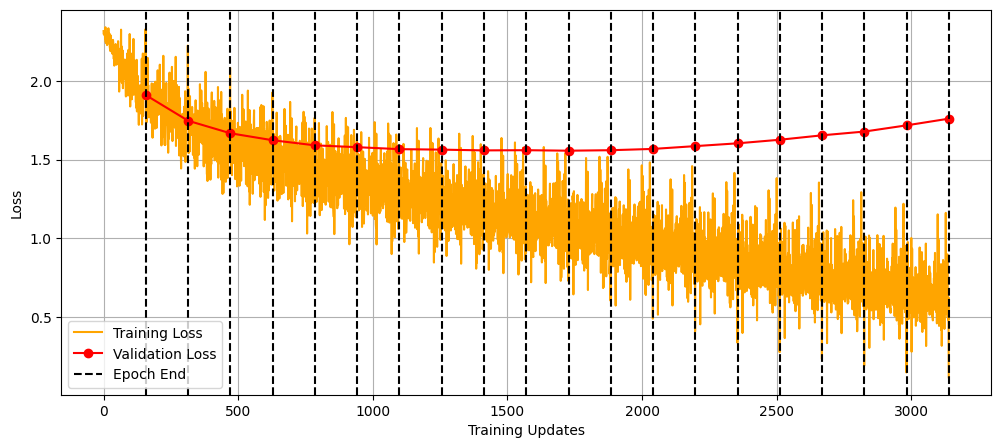

In [63]:
## plotting training and validation loss curves
plt.figure(figsize=(12,5))
plt.plot(training_loss, color="orange", label="Training Loss")
plt.plot([(i+1)*dataset.num_train_batches for i in range(NUM_EPOCHS)],val_loss, color="red", label="Validation Loss", marker="o")
for i in range(NUM_EPOCHS):
    plt.axvline((i+1)*dataset.num_train_batches, 0, max(training_loss), label=None if i < NUM_EPOCHS-1 else "Epoch End", color = "black", ls ="--")
plt.grid(True)
plt.xlabel("Training Updates")
plt.ylabel("Loss")
plt.legend()

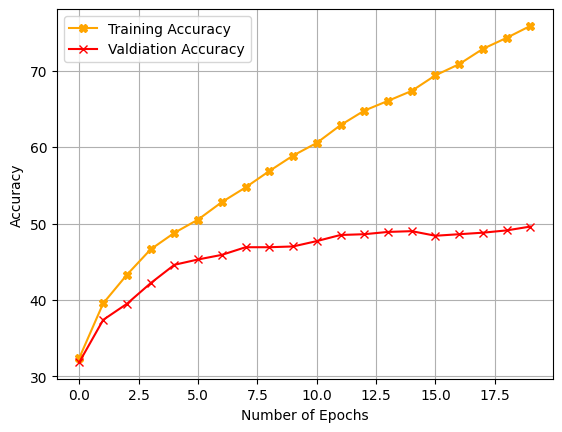

In [64]:
plt.plot(training_accuracy, label = "Training Accuracy", color ="orange", marker="X")
plt.plot(validation_accuracy, label="Valdiation Accuracy", color="red", marker="x")
plt.grid(True)
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [65]:
## TRAINING SET ACCURACIES
correct = [0 for _ in range(NUM_CLASSES)]
total = [0 for _ in range(NUM_CLASSES)]
total_batches = dataset.num_train_batches
for batch_idx in range(total_batches):
    X, y = dataset.train_batch(batch_idx)
    batch_size = X.shape[0]
    prob = model.forward(X)
    pred = np.argmax(prob, axis=1)
    for idx in range(batch_size):
        total[y[idx]] += 1
        correct[y[idx]] += 1 if pred[idx] == y[idx] else 0

for idx in range(NUM_CLASSES):
    print(classes[idx], f"{correct[idx]/total[idx]*100:.2f} %")

        

plane 87.18 %
car 89.41 %
bird 60.79 %
cat 51.95 %
deer 83.04 %
dog 90.75 %
frog 77.30 %
horse 53.16 %
ship 83.44 %
truck 78.86 %


In [66]:
## TESTING SET ACCURACIES
correct = [0 for _ in range(NUM_CLASSES)]
total = [0 for _ in range(NUM_CLASSES)]
total_batches = dataset.num_test_batches
for batch_idx in range(total_batches):
    X, y = dataset.test_batch(batch_idx)
    batch_size = X.shape[0]
    prob = model.forward(X)
    pred = np.argmax(prob, axis=1)
    for idx in range(batch_size):
        total[y[idx]] += 1
        correct[y[idx]] += 1 if pred[idx] == y[idx] else 0

for idx in range(NUM_CLASSES):
    print(classes[idx], f"{correct[idx]/total[idx]*100:.2f} %")

plane 67.82 %
car 60.00 %
bird 40.74 %
cat 27.10 %
deer 50.53 %
dog 62.11 %
frog 52.00 %
horse 31.37 %
ship 60.78 %
truck 49.04 %
